In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy
import re

### 👾 Load Data

In [91]:
file_path = "data_from_wandb.csv"
df = pd.read_csv(file_path)

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Name                         99 non-null     object 
 1   State                        99 non-null     object 
 2   Notes                        99 non-null     object 
 3   User                         0 non-null      float64
 4   Tags                         99 non-null     object 
 5   Created                      99 non-null     object 
 6   Runtime                      99 non-null     int64  
 7   Sweep                        0 non-null      float64
 8   Accuracy                     91 non-null     float64
 9   Average Inference Time (ms)  91 non-null     float64
 10  Dataset Name                 91 non-null     object 
 11  GPU Memory Usage (MB)        91 non-null     float64
 12  Model Size (MB)              91 non-null     float64
dtypes: float64(6), int64(1

In [93]:
df = df[df['State'] == 'finished']

In [94]:
df[['col1', 'col2', 'col3']] = df['Tags'].str.split(', ', expand=True)

# device 및 dataset 후보 목록
device_candidates = ['Orin', 'A100']
dataset_candidates = ['winogrande', 'social_i_qa', 'allenai/ai2_arc', 'openbookqa', 'piqa', 'boolq']

# device, dataset, model 정리
def classify_columns(row):
    device = None
    dataset = None
    model = None

    for col in ['col1', 'col2', 'col3']:
        if row[col] in device_candidates:
            device = row[col]
        elif row[col] in dataset_candidates:
            dataset = row[col]
        else:
            model = row[col]

    return pd.Series([device, model, dataset])

df[['Device', 'Model', 'Dataset']] = df.apply(classify_columns, axis=1)

df['Model'] = df['Model'].str.split('/').str[-1]

df = df.drop(['Tags', 'col1', 'col2', 'col3'], axis=1)

In [142]:
df['GPU Memory Usage (GB)'] = df['GPU Memory Usage (MB)'] / 1024

In [95]:
dataset_mapping = {
    'winogrande': 'WinoGrande',
    'social_i_qa': 'SIQA',
    'allenai/ai2_arc': 'ARC-e',
    'openbookqa': 'OBQA',
    'piqa': 'PIQA',
    'boolq': 'BoolQ'
}
df['Dataset'] = df['Dataset'].replace(dataset_mapping)

In [105]:
def extract_parameters(model_name):
    match = re.search(r'([\d.]+)([MBT])', model_name, re.IGNORECASE)
    if match:
        value, unit = match.groups()
        unit = unit.upper()
        if unit == 'B':
            return f"{int(float(value) * 1000)}M"
        return f"{value}{unit}"
    return "Unknown"

df['Parameters'] = df['Model'].apply(extract_parameters)

In [143]:
data = df[['Device', 'Model', 'Parameters', 'Dataset', 'State', 'Accuracy', 'Average Inference Time (ms)', 'GPU Memory Usage (GB)', 'Model Size (MB)']]
data = data.sort_values(by='Parameters', ascending=True)

In [144]:
data

,Device,Model,Parameters,Dataset,State,Accuracy,Average Inference Time (ms),GPU Memory Usage (GB),Model Size (MB)
98,Orin,Cerebras-GPT-111M,111M,WinoGrande,finished,49.565904,49.356640,0.486320,423.624023
96,Orin,Cerebras-GPT-111M,111M,ARC-e,finished,26.491228,47.848207,0.518592,423.624023
95,Orin,Cerebras-GPT-111M,111M,SIQA,finished,33.700000,46.560314,0.509212,423.624023
94,Orin,Cerebras-GPT-111M,111M,BoolQ,finished,38.000000,75.053353,0.607112,423.624023
93,Orin,Cerebras-GPT-111M,111M,PIQA,finished,49.564744,47.906545,0.607112,423.624023
...,...,...,...,...,...,...,...,...,...
7,Orin,Cerebras-GPT-590M,590M,BoolQ,finished,37.900000,407.802800,2.551911,2251.857422
6,Orin,Cerebras-GPT-590M,590M,PIQA,finished,49.619151,253.730050,2.551911,2251.857422
5,Orin,LaMini-GPT-774M,774M,WinoGrande,finished,51.065509,241.841742,3.012091,2952.695312
4,Orin,LaMini-GPT-774M,774M,OBQA,finished,31.200000,288.770704,3.024188,2952.695312


### 👾 Data Analysis Result

In [145]:
df_pivot = df.pivot_table(index=['Model', 'Parameters'], columns='Dataset', values='Accuracy')
df_pivot['Avg.'] = df_pivot.mean(axis=1)

df_pivot.reset_index(inplace=True)

df_pivot.columns.name = None

print(df_pivot.to_markdown(index=False))

| Model             | Parameters   |   ARC-e |   BoolQ |   OBQA |     PIQA |   SIQA |   WinoGrande |    Avg. |
|:------------------|:-------------|--------:|--------:|-------:|---------:|-------:|-------------:|--------:|
| Cerebras-GPT-111M | 111M         | 26.4912 |    38   |   25   |  49.5647 |   33.7 |      49.5659 | 37.0536 |
| Cerebras-GPT-256M | 256M         | 26.4912 |    38.1 |   25   |  49.5103 |   33.7 |      49.5659 | 37.0612 |
| Cerebras-GPT-590M | 590M         | 26.4912 |    37.9 |   25   |  49.6192 |   33.7 |      49.5659 | 37.046  |
| LaMini-GPT-124M   | 124M         | 24.9123 |    62.4 |   24   |  50.3808 |   33.1 |      50.4341 | 40.8712 |
| LaMini-GPT-774M   | 774M         | 32.6316 |   nan   |   31.2 | nan      |  nan   |      51.0655 | 38.299  |
| LiteLlama-460M-1T | 460M         | 25.614  |    38.1 |   25.2 |  49.8368 |   34   |      49.5659 | 37.0528 |
| Qwen1.5-0.5B      | 500M         | 54.7368 |    59.7 |   42   |  52.1763 |   42.3 |      50.8287 | 50.2903 |
|

In [150]:
df_pivot = df.pivot_table(index=['Model', 'Parameters'], columns='Dataset', values='Average Inference Time (ms)')
df_pivot['Avg.'] = df_pivot.mean(axis=1)

df_pivot.reset_index(inplace=True)

df_pivot.columns.name = None

print(df_pivot.to_markdown(index=False))

| Model             | Parameters   |    ARC-e |    BoolQ |     OBQA |     PIQA |     SIQA |   WinoGrande |     Avg. |
|:------------------|:-------------|---------:|---------:|---------:|---------:|---------:|-------------:|---------:|
| Cerebras-GPT-111M | 111M         |  47.8482 |  75.0534 |  42.6519 |  47.9065 |  46.5603 |      49.3566 |  51.5628 |
| Cerebras-GPT-256M | 256M         | 118.458  | 197.908  | 104.827  | 115.482  | 125.461  |      76.8072 | 123.157  |
| Cerebras-GPT-590M | 590M         | 251.496  | 407.803  | 227.772  | 253.73   | 252.317  |     195.598  | 264.786  |
| LaMini-GPT-124M   | 124M         |  55.5167 |  91.169  |  50.3607 |  57.7197 |  53.6331 |      51.48   |  59.9799 |
| LaMini-GPT-774M   | 774M         | 331.246  | nan      | 288.771  | nan      | nan      |     241.842  | 287.286  |
| LiteLlama-460M-1T | 460M         | 173.447  | 278.426  | 156.089  | 172.623  | 173.079  |     124.438  | 179.684  |
| Qwen1.5-0.5B      | 500M         | 175.618  | 305.815 

In [151]:
df_pivot = df.pivot_table(index=['Model', 'Parameters'], columns='Dataset', values='GPU Memory Usage (GB)')
df_pivot['Avg.'] = df_pivot.mean(axis=1)

df_pivot.reset_index(inplace=True)

df_pivot.columns.name = None

print(df_pivot.to_markdown(index=False))

| Model             | Parameters   |    ARC-e |      BoolQ |     OBQA |       PIQA |       SIQA |   WinoGrande |     Avg. |
|:------------------|:-------------|---------:|-----------:|---------:|-----------:|-----------:|-------------:|---------:|
| Cerebras-GPT-111M | 111M         | 0.518592 |   0.607112 | 0.511304 |   0.607112 |   0.509212 |     0.48632  | 0.539942 |
| Cerebras-GPT-256M | 256M         | 1.09269  |   1.21178  | 1.07552  |   1.20897  |   1.07341  |     1.04991  | 1.11871  |
| Cerebras-GPT-590M | 590M         | 2.38433  |   2.55191  | 2.37     |   2.55191  |   2.36661  |     2.33764  | 2.42707  |
| LaMini-GPT-124M   | 124M         | 0.518301 |   0.582409 | 0.511014 |   0.582409 |   0.508922 |     0.499037 | 0.533682 |
| LaMini-GPT-774M   | 774M         | 3.03155  | nan        | 3.02419  | nan        | nan        |     3.01209  | 3.02261  |
| LiteLlama-460M-1T | 460M         | 1.76578  |   1.83748  | 1.75761  |   1.83748  |   1.75526  |     1.74412  | 1.78295  |
| Qwen1.

<ipython-input-146-71c8d6303a4a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='Model', y='Accuracy',  palette = 'Blues')


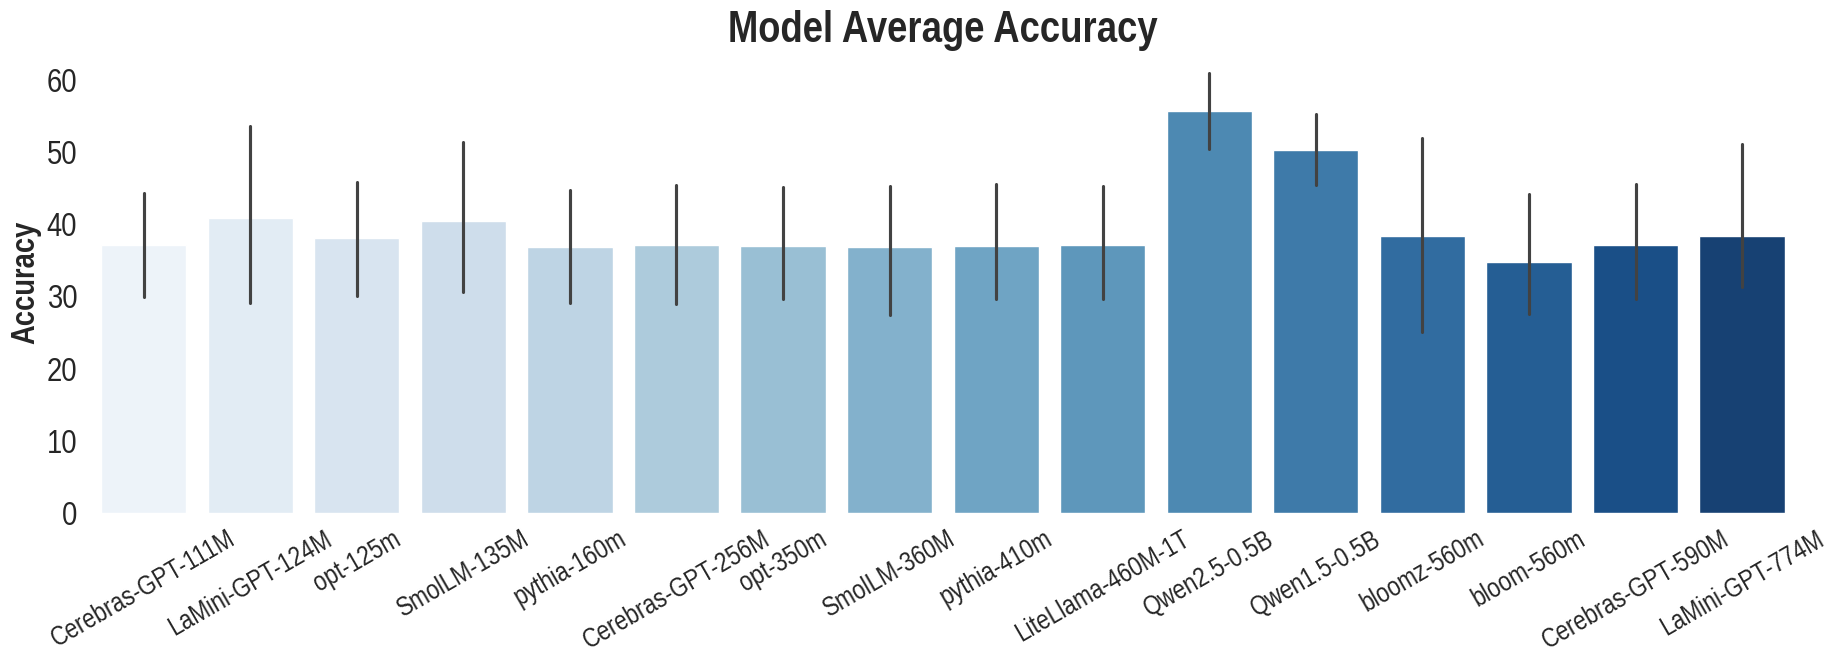

In [146]:
sns.set(style="white", font='Liberation Sans Narrow')
plt.figure(figsize=(22, 6))
sns.barplot(data=data, x='Model', y='Accuracy',  palette = 'Blues')
sns.despine(left=True, bottom=True)

plt.title('Model Average Accuracy', fontsize=32, fontweight='bold')
plt.xlabel(None)
plt.ylabel('Accuracy', fontsize=24, fontweight='bold')
plt.xticks(rotation=30, fontsize=20)
plt.yticks(fontsize=24)

plt.show()

<ipython-input-147-f31494ff35c9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='Model', y='Average Inference Time (ms)',  palette = 'Oranges')


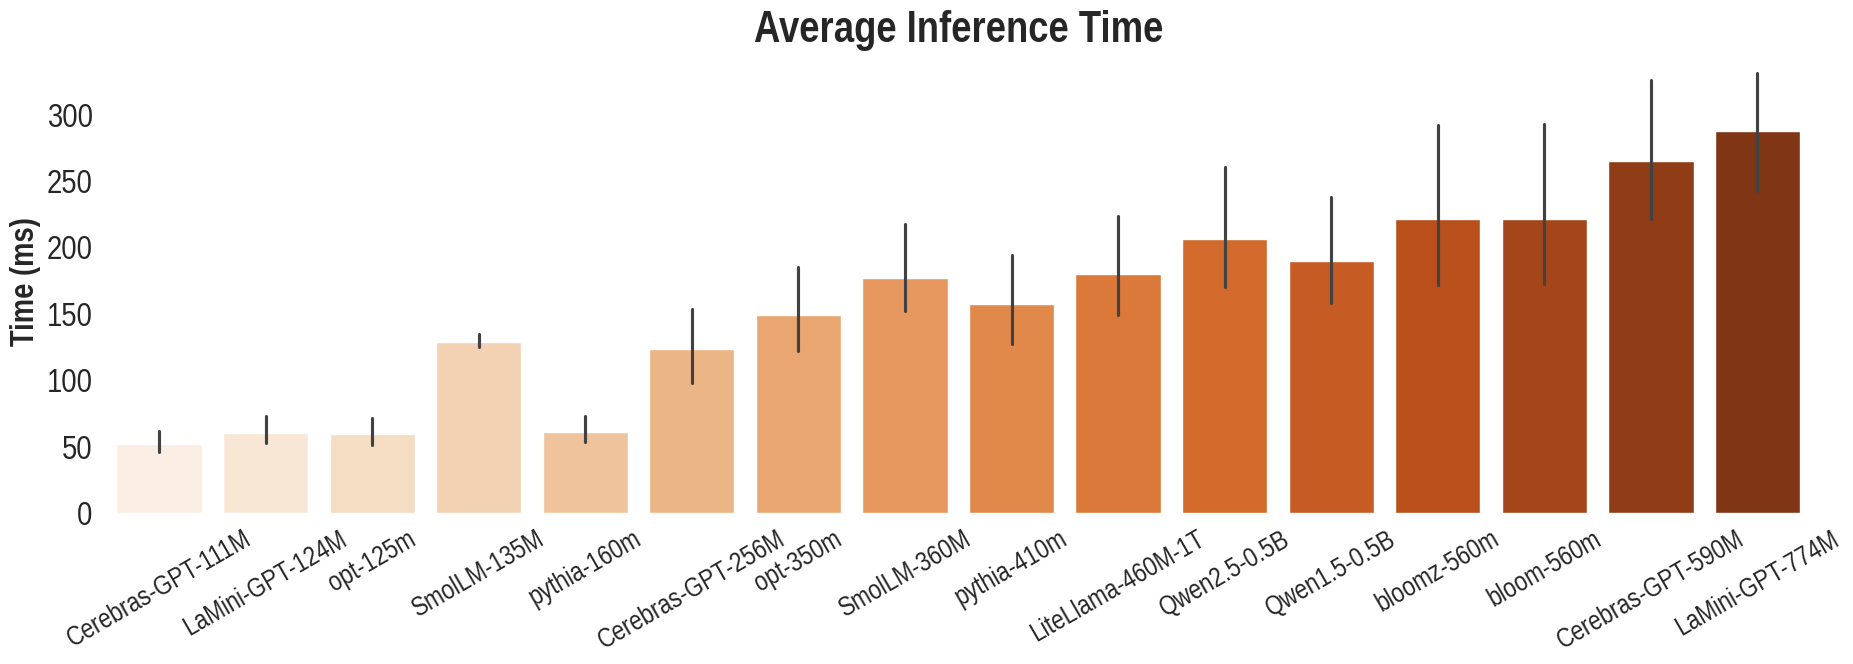

In [147]:
sns.set(style="white", font='Liberation Sans Narrow')
plt.figure(figsize=(22, 6))
sns.barplot(data=data, x='Model', y='Average Inference Time (ms)',  palette = 'Oranges')
sns.despine(left=True, bottom=True)

plt.title('Average Inference Time', fontsize=32, fontweight='bold')
plt.xlabel(None)
plt.ylabel('Time (ms)', fontsize=24, fontweight='bold')
plt.xticks(rotation=30, fontsize=20)
plt.yticks(fontsize=24)

plt.show()

<ipython-input-149-1a93bcced6aa>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='Model', y='GPU Memory Usage (GB)',  palette = 'Greens')


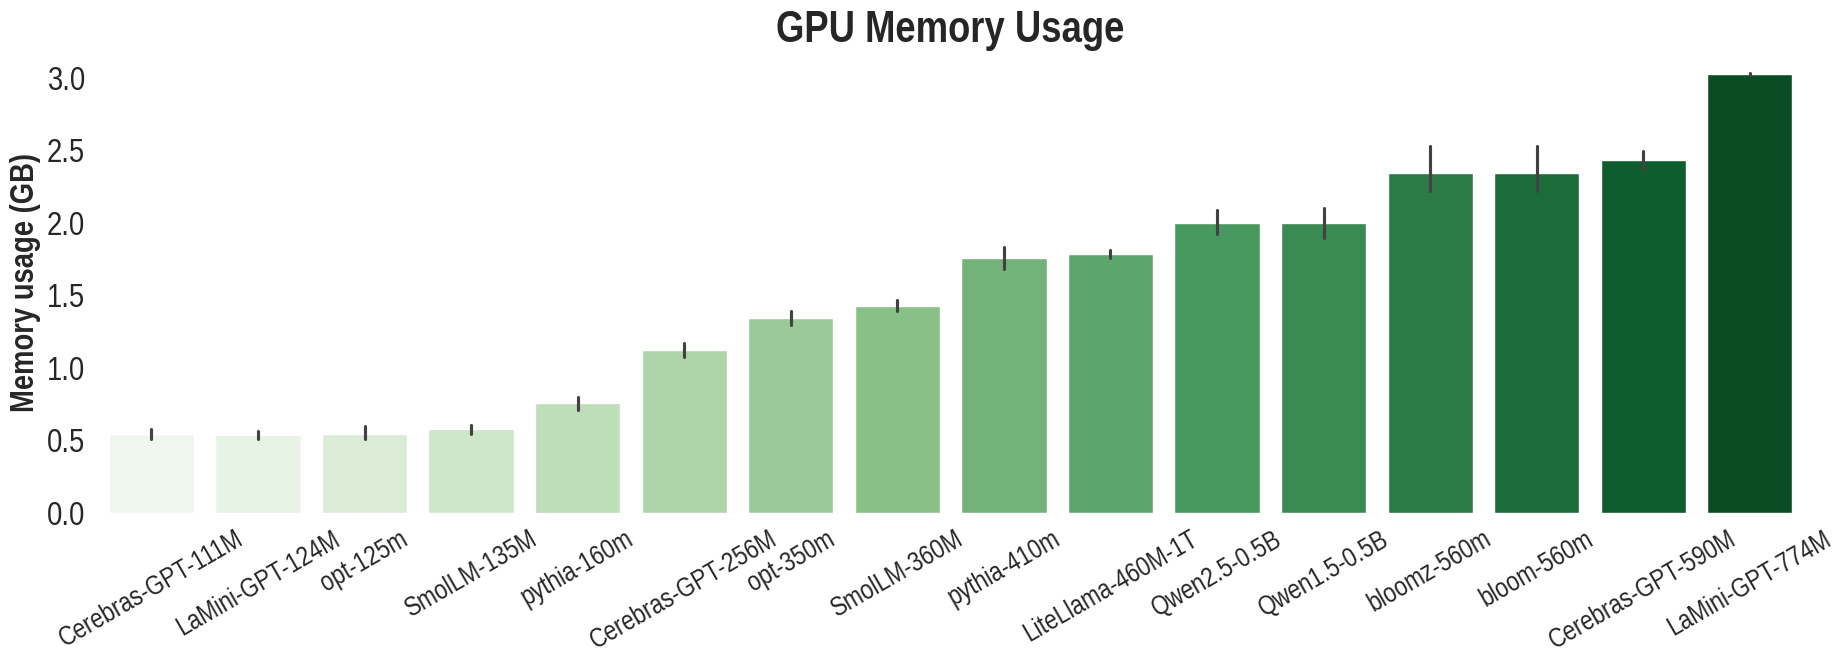

In [149]:
sns.set(style="white", font='Liberation Sans Narrow')
plt.figure(figsize=(22, 6))
sns.barplot(data=data, x='Model', y='GPU Memory Usage (GB)',  palette = 'Greens')
sns.despine(left=True, bottom=True)

plt.title('GPU Memory Usage', fontsize=32, fontweight='bold')
plt.xlabel(None)
plt.ylabel('Memory usage (GB)', fontsize=24, fontweight='bold')
plt.xticks(rotation=30, fontsize=20)
plt.yticks(fontsize=24)

plt.show()